Data Loading & Cleaning

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import random
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import Birch
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
print("Libraries loaded successfully.")




Libraries loaded successfully.


In [7]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
np.random.seed(42)
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled = X_scaled[sample_indices]
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
987230,-0.751675,-0.405880,1.234974,-1.256401,-0.669618,-1.010457
79954,-0.604813,-0.129210,0.135406,-0.508040,-0.938868,-0.271504
567130,-0.497520,-0.214469,1.623337,-1.357419,0.340071,0.637976
500891,1.414472,1.539007,0.637057,-0.841294,0.878572,0.581134
55399,-0.829977,-1.025197,-0.699063,0.572155,-0.467680,-0.100977


Hopkins Statistic

In [13]:
# Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

H = hopkins(X_sample_scaled)
print(f"Hopkins Statistic: {H:.8f}")

Hopkins Statistic: 0.99997884


K-Means

Elbow Method

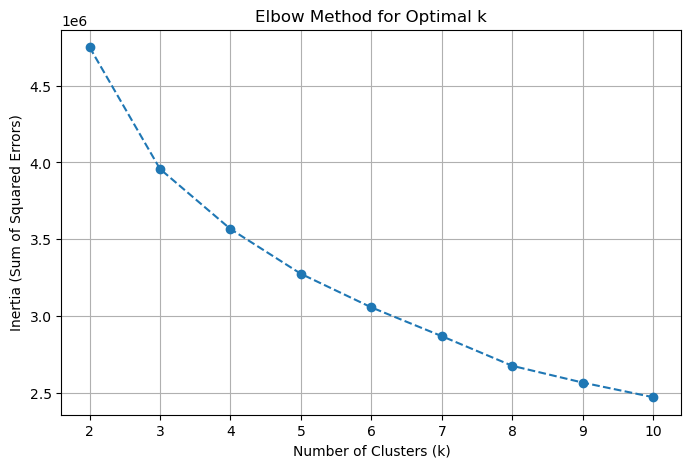

In [8]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

K-Means Algorithm Implementation

In [9]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids


Application

In [10]:
#I choose k based on the Elbow Plot 
k_optimal = 4
max_iters = 10

#Randomly pick k points from our sample to be the starting centroids
random_indices = np.random.choice(X_sample_scaled.shape[0], k_optimal, replace=False)
centroids = X_sample_scaled[random_indices]

assignments = np.zeros(X_sample_scaled.shape[0])

print(f"\nStarting Manual K-Means Algorithm (k={k_optimal})...")

#K means
for i in range(max_iters):
    print(f"Iteration {i+1}/{max_iters}...")
    
    #Assign points to clusters 
    assignments = find_closest_centroids(X_sample_scaled, centroids)
    
    #Calculate new centroids
    previous_centroids = centroids
    centroids = compute_centroids(X_sample_scaled, assignments, k_optimal)
    
    #Check for convergence (if centroids don't change, we stop)
    if np.all(centroids == previous_centroids):
        print("Converged early!")
        break

print("Manual Clustering Completed Successfully.")


Starting Manual K-Means Algorithm (k=4)...
Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...
Manual Clustering Completed Successfully.


Visualization and analysis

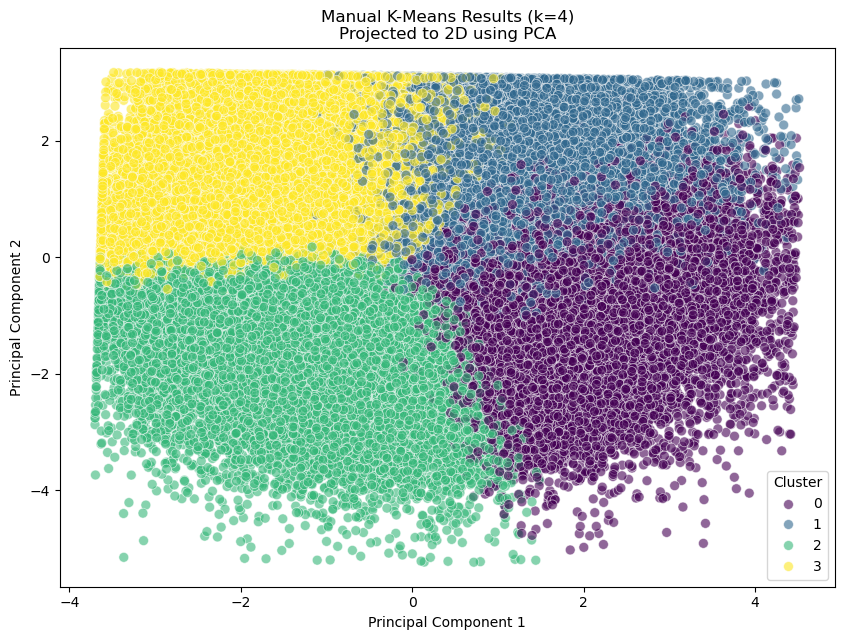


--- Cluster Profiles (Average Values) ---
            BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore
Cluster                                                                    
0        2.507061e+07         7.174233e+07    5.809679            56.596859
1        1.292623e+07         3.547351e+07    7.546265            77.354576
2        2.003354e+06         4.890243e+06    5.161617            48.835441
3        1.499238e+06         3.600666e+06    7.583803            77.733437

Movies per Cluster:
 Cluster  NumMovies
       2      54886
       3      51245
       0      47373
       1      46495


In [11]:
#VISUALIZATION (PCA 2D)
#We use PCA only to project the 6-dimensional data onto a 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=assignments, 
    palette='viridis', 
    s=50, 
    alpha=0.6
)
plt.title(f'Manual K-Means Results (k={k_optimal})\nProjected to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#CLUSTER PROFILING
#Add the cluster labels to our sample dataframe
df_sample['Cluster'] = assignments

#Calculate the mean of the original features for each cluster
# Note: We use the original columns (before scaling) to make it readable (e.g. real dollars)
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster')[numeric_cols].mean()

print("\n--- Cluster Profiles (Average Values) ---")
print(profile)

#how many movies are in each cluster
print("\nMovies per Cluster:")
df_counts = df_sample['Cluster'].value_counts().reset_index()
df_counts.columns = ['Cluster', 'NumMovies']
print(df_counts.to_string(index=False))



Model Evaluation

In [12]:
# --- K-MEANS MODEL EVALUATION ---

# 1. Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
    n = X.shape[0]
    d = X.shape[1]
    m = int(portion * n)
    
    if m < 1: return 0.5 

    np.random.seed(seed)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    
    rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m, d))
    
    u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
    
    idx = np.random.choice(n, size=m, replace=False)
    w_dist = nbrs.kneighbors(X[idx, :], 2, return_distance=True)[0][:, 1]
    
    U = (u_dist**d).sum()
    W = (w_dist**d).sum()
    
    return U / (U + W)

# 2. ANOVA Validation Function (La misma que usamos en BIRCH)
def perform_anova_validation(df, cluster_col, features):
    """
    Realiza un test ANOVA de una vía para verificar diferencias significativas.
    """
    print(f"\nANOVA Validation for K-Means (Testing differences between {cluster_col} groups)")
    print("-" * 60)
    
    unique_clusters = sorted(df[cluster_col].unique())
    
    for feature in features:
        # Preparamos los grupos
        groups = [df[df[cluster_col] == c][feature] for c in unique_clusters]
        
        # Ejecutamos ANOVA
        f_stat, p_value = f_oneway(*groups)
        
        print(f"Feature: {feature}")
        print(f"  F-statistic: {f_stat:.2f} | P-value: {p_value:.4e}")
        
        if p_value < 0.05:
            print("  ✅ SIGNIFICANT: Distinct populations confirmed.")
        else:
            print("  ❌ NOT SIGNIFICANT: Clusters are indistinguishable.")

# --- EJECUCIÓN DEL ANÁLISIS ---

print("\n--- K-Means Evaluation Metrics ---")

# ASUMPCIONES:
# - X_sample_scaled: Tus datos numéricos escalados
# - assignments: Las etiquetas que generó tu K-Means (array de 0, 1, 2, 3...)
# - df_sample: El dataframe original para validar con ANOVA

# 1. Hopkins
h_stat = hopkins(X_sample_scaled, portion=0.05)
print(f"Hopkins Statistic: {h_stat:.4f} (Ideal > 0.7)")

# 2. Métricas Internas (Silhouette, DB, CH)
# Subsampleo para Silhouette si es muy grande
if X_sample_scaled.shape[0] > 10000:
    print("Calculando Silhouette con muestra de 10,000 puntos...")
    np.random.seed(42)
    idx_eval = np.random.choice(X_sample_scaled.shape[0], 10000, replace=False)
    X_eval = X_sample_scaled[idx_eval]
    labels_eval = assignments[idx_eval]
else:
    X_eval = X_sample_scaled
    labels_eval = assignments

sil = silhouette_score(X_eval, labels_eval)
print(f"Silhouette Score: {sil:.4f}")

db = davies_bouldin_score(X_sample_scaled, assignments)
print(f"Davies-Bouldin Index: {db:.4f}")

ch = calinski_harabasz_score(X_sample_scaled, assignments)
print(f"Calinski-Harabasz Index: {ch:.4f}")

# 3. ANOVA Validation (El paso crítico)
# Añadimos las etiquetas de K-Means al dataframe original
df_sample['Cluster_KMeans'] = assignments

features_to_validate = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'IMDbRating', 
    'RottenTomatoesScore',
    'NumVotesIMDb',
    'NumVotesRT'
]

perform_anova_validation(df_sample, 'Cluster_KMeans', features_to_validate)


--- K-Means Evaluation Metrics ---
Hopkins Statistic: 1.0000 (Ideal > 0.7)
Calculando Silhouette con muestra de 10,000 puntos...
Silhouette Score: 0.1562
Davies-Bouldin Index: 1.6565
Calinski-Harabasz Index: 44472.6268

ANOVA Validation for K-Means (Testing differences between Cluster_KMeans groups)
------------------------------------------------------------
Feature: BudgetUSD
  F-statistic: 14255.50 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: Global_BoxOfficeUSD
  F-statistic: 12053.99 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: IMDbRating
  F-statistic: 74218.71 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: RottenTomatoesScore
  F-statistic: 76764.37 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: NumVotesIMDb
  F-statistic: 2316.59 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: Distinct populations confirmed.
Feature: NumVotesRT
  F-statistic: 4.16 | P-

BIRCH

BIRCH HYPERPARAMETER TUNING

Running BIRCH on sample data shape: (199999, 6)

--- Comparing Thresholds ---
Threshold T=0.5 -> Generated 18783 subclusters (6.2153s)
Threshold T=1.0 -> Generated 732 subclusters (3.0058s)
Threshold T=1.5 -> Generated 38 subclusters (1.3345s)
Threshold T=2.0 -> Generated 8 subclusters (1.3422s)
Threshold T=2.5 -> Generated 2 subclusters (1.3256s)


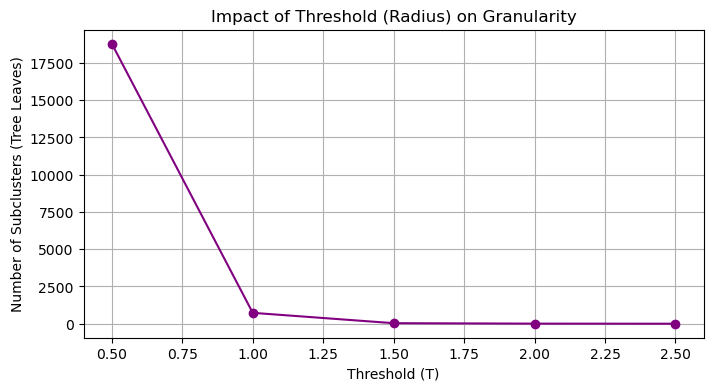

In [13]:
print(f"Running BIRCH on sample data shape: {X_sample_scaled.shape}")

# Parameter to tune: Threshold (T)
# Definition: The radius of the subcluster obtained by merging a new sample.
# (Slide 28: Threshold controls the tree size)
thresholds_to_test = [0.5, 1.0, 1.5, 2.0, 2.5] 
tuning_results = []

print("\n--- Comparing Thresholds ---")

for thresh in thresholds_to_test:
    start_time = time.time()
    
    # n_clusters=None: We let BIRCH generate as many subclusters as the tree needs.
    # This helps us understand the structure before forcing a final k.
    brc = Birch(threshold=thresh, n_clusters=None)
    brc.fit(X_sample_scaled)
    
    elapsed = time.time() - start_time
    num_subclusters = len(brc.subcluster_centers_)
    
    tuning_results.append({
        'Threshold': thresh,
        'Subclusters': num_subclusters,
        'Time_Sec': elapsed
    })
    print(f"Threshold T={thresh} -> Generated {num_subclusters} subclusters ({elapsed:.4f}s)")

# Visualization of the Trade-off
results_df = pd.DataFrame(tuning_results)
plt.figure(figsize=(8, 4))
plt.plot(results_df['Threshold'], results_df['Subclusters'], marker='o', color='purple')
plt.title('Impact of Threshold (Radius) on Granularity')
plt.xlabel('Threshold (T)')
plt.ylabel('Number of Subclusters (Tree Leaves)')
plt.grid(True)
plt.show()

Shape of sample data used for BIRCH: (50000, 6)

--- Running BIRCH Threshold Tuning ---
T=0.5 -> Subclusters: 9137 | Sil: 0.1027 (10.71s)
T=1.0 -> Subclusters: 523 | Sil: 0.1053 (1.02s)
T=1.5 -> Subclusters: 38 | Sil: 0.1021 (0.36s)
T=2.0 -> Subclusters: 8 | Sil: 0.1262 (0.32s)
T=2.5 -> Subclusters: 2 | Sil: 0.1895 (0.32s)


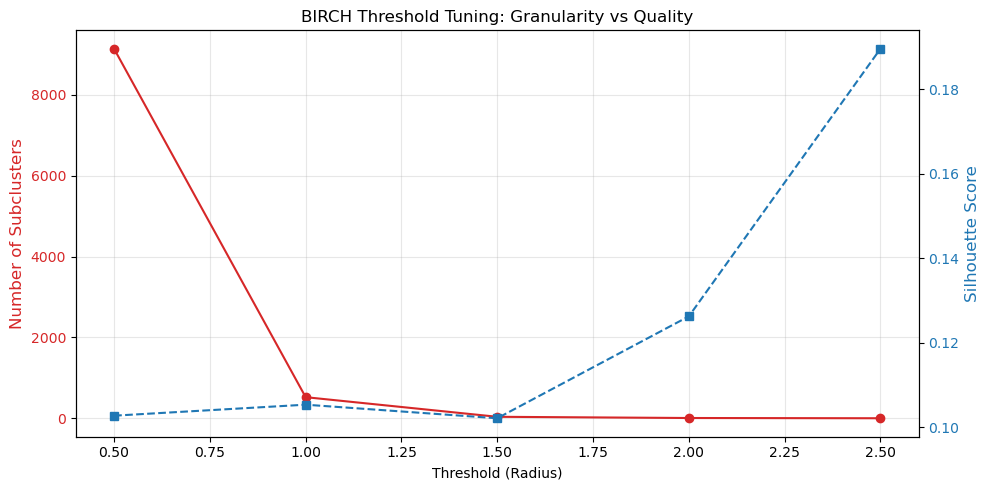

In [14]:
# ==========================================
# 2. SAMPLING (50,000 Líneas)
# ==========================================
# Modificado para asegurar 50k exactos y mantener alineación de índices

target_samples = 50000

if len(X_scaled_df) > target_samples:
    # Sampleamos manteniendo el índice para poder recuperar los datos originales en df_sample
    X_sample_scaled_df = X_scaled_df.sample(n=target_samples, random_state=42)
else:
    X_sample_scaled_df = X_scaled_df.copy()

# Alineamos los arrays y el dataframe original usando los índices del sample
sample_indices = X_sample_scaled_df.index
X_sample_scaled = X_sample_scaled_df.values # Array numpy para el modelo
df_sample = df.loc[sample_indices]          # Datos originales para análisis posterior

print(f"Shape of sample data used for BIRCH: {X_sample_scaled.shape}")


# ==========================================
# 3. TUNING DEL THRESHOLD (BIRCH)
# ==========================================

# Rango de Thresholds a probar (ajusta si ves que los resultados son extremos)
thresholds_to_test = [0.5, 1.0, 1.5, 2.0, 2.5] 
tuning_results = []

print("\n--- Running BIRCH Threshold Tuning ---")

for thresh in thresholds_to_test:
    start_time = time.time()
    
    # n_clusters=None para ver la estructura real del árbol
    brc = Birch(threshold=thresh, n_clusters=4)
    brc.fit(X_sample_scaled)
    labels = brc.predict(X_sample_scaled)
    
    elapsed = time.time() - start_time
    num_subclusters = len(brc.subcluster_centers_)
    
    # Calcular Silhouette (seguro y rápido para 50k, pero lo limitamos por si acaso)
    if 1 < num_subclusters < len(X_sample_scaled):
        sil_score = silhouette_score(X_sample_scaled, labels)
    else:
        sil_score = -1 
    
    tuning_results.append({
        'Threshold': thresh,
        'Silhouette': sil_score,
        'Num_Subclusters': num_subclusters,
        'Time_Sec': elapsed
    })
    
    print(f"T={thresh} -> Subclusters: {num_subclusters} | Sil: {sil_score:.4f} ({elapsed:.2f}s)")


# ==========================================
# 4. VISUALIZACIÓN
# ==========================================
results_df = pd.DataFrame(tuning_results)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Eje 1: Cantidad de Subclústeres (Granularidad)
color = 'tab:red'
ax1.set_xlabel('Threshold (Radius)')
ax1.set_ylabel('Number of Subclusters', color=color, fontsize=12)
ax1.plot(results_df['Threshold'], results_df['Num_Subclusters'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Eje 2: Calidad (Silhouette)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=12)  
ax2.plot(results_df['Threshold'], results_df['Silhouette'], marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('BIRCH Threshold Tuning: Granularity vs Quality')
plt.tight_layout()
plt.show()

FINAL MODEL AND PROFILING

Training Final BIRCH (T=1.0, k=4)...


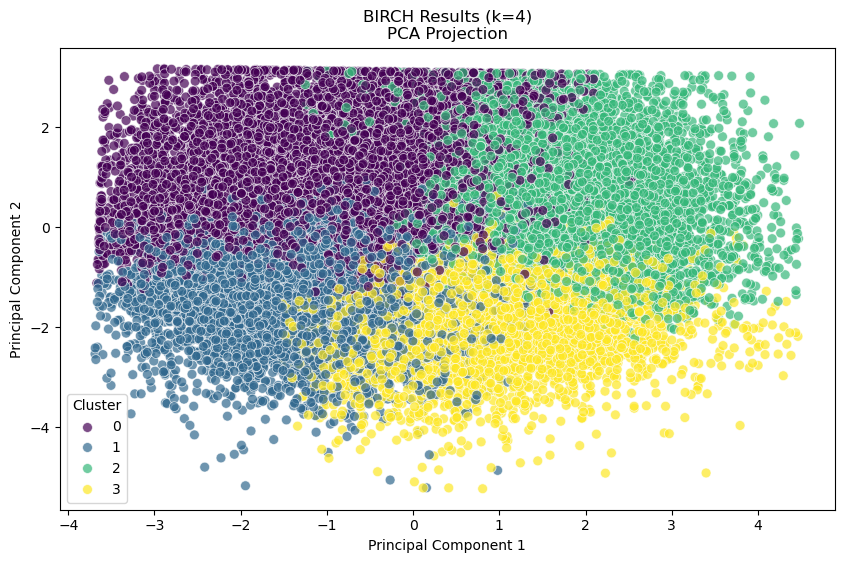


--- Cluster Profiles (Real Values) ---
                  BudgetUSD  Global_BoxOfficeUSD  IMDbRating  \
Cluster_BIRCH                                                  
0              2.761092e+06         6.922528e+06    7.343842   
1              2.062289e+06         5.132043e+06    5.403084   
2              2.506802e+07         7.005841e+07    7.095209   
3              1.351819e+07         3.774011e+07    4.896608   

               RottenTomatoesScore  Movie_Count  
Cluster_BIRCH                                    
0                        74.961406        19511  
1                        51.715672        10407  
2                        72.108384        11856  
3                        45.437150         8226  


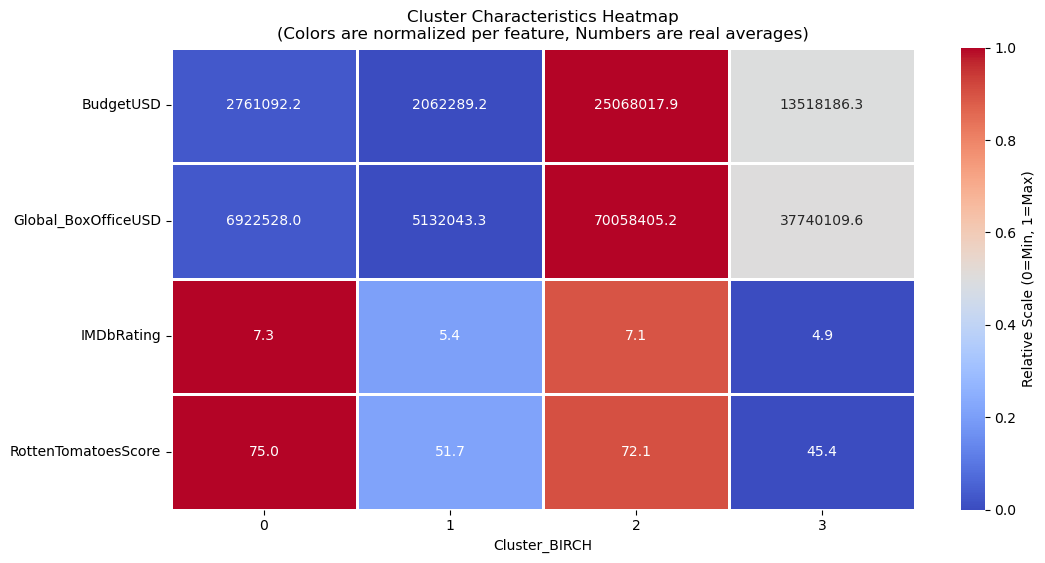

In [15]:
# --- PART 3: FINAL MODEL & PROFILING ---

# Configuration based on analysis (or fixed for the project)
# We use n_clusters=4 to perform the Global Clustering step on the leaves.
final_threshold = 1.0
final_k = 4

print(f"Training Final BIRCH (T={final_threshold}, k={final_k})...")

# 1. Train Model
birch_final = Birch(threshold=final_threshold, n_clusters=final_k)
# We fit on the sample scaled data
labels = birch_final.fit_predict(X_sample_scaled)

# 2. Visualization (PCA 2D Projection)
# Note: Training was done on ALL features. PCA is ONLY for plotting.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=50, alpha=0.7)
plt.title(f'BIRCH Results (k={final_k})\nPCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# 3. Business Profiling
# We map the labels back to the ORIGINAL sample dataframe (df_sample)
# to interpret the Money/Ratings in real values.
df_sample['Cluster_BIRCH'] = labels

numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster_BIRCH')[numeric_cols].mean()
profile['Movie_Count'] = df_sample['Cluster_BIRCH'].value_counts()

print("\n--- Cluster Profiles (Real Values) ---")
print(profile)

# Heatmap for quick interpretation# --- MEJORA DEL HEATMAP ---
# --- HEATMAP MEJORADO (Normalizado) ---
# 1. Normalizamos colores (0-1) para que el dinero no opaque a las notas
scaler_view = MinMaxScaler()
profile_for_plot = profile.drop(columns='Movie_Count')
profile_normalized = pd.DataFrame(
    scaler_view.fit_transform(profile_for_plot),
    columns=profile_for_plot.columns,
    index=profile_for_plot.index
)

# 2. Pintamos el Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    profile_normalized.T,          # Colores normalizados
    annot=profile_for_plot.T,      # Texto con valores REALES
    cmap='coolwarm',
    fmt=".1f",                     # 1 decimal
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Relative Scale (0=Min, 1=Max)'}
)
plt.title("Cluster Characteristics Heatmap\n(Colors are normalized per feature, Numbers are real averages)")
plt.show()

Model evaluation

In [16]:
# --- MODEL EVALUATION ---

# Hopkins Statistic
def hopkins(X, portion=0.1, seed=247):
  # X: numpy array of shape (n_samples, n_features)
  n = X.shape[0]
  d = X.shape[1]
  m = int(portion * n)

  np.random.seed(seed)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X)
  # u_dist
  rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(m,d))
  u_dist = nbrs.kneighbors(rand_X, return_distance=True)[0]
  # w_dist
  idx = np.random.choice(n, size=m, replace=False)
  w_dist = nbrs.kneighbors(X[idx,:], 2, return_distance=True)[0][:,1]

  U = (u_dist**d).sum()
  W = (w_dist**d).sum()
  H = U / (U + W)
  return H

# Silhouette Score (adaptado para BIRCH - no hay ruido explícito como en DBSCAN)
def compute_silhouette(X_scaled, labels):
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Silhouette: solo hay 1 clúster.")
        return None
    # Usamos una muestra para silhouette si el dataset es muy grande,
    # ya que es computacionalmente costoso (O(N^2))
    if X_scaled.shape[0] > 10000:
        print("Calculando Silhouette con una muestra de 10,000 puntos para eficiencia...")
        indices = np.random.choice(X_scaled.shape[0], 10000, replace=False)
        return silhouette_score(X_scaled[indices], labels[indices])
    return silhouette_score(X_scaled, labels)

# Davies-Bouldin
def compute_davies_bouldin(X_scaled, labels):
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Davies-Bouldin: solo hay 1 clúster.")
        return None
    return davies_bouldin_score(X_scaled, labels)

# Calinski-Harabasz
def compute_calinski_harabasz(X_scaled, labels):
    if len(np.unique(labels)) <= 1:
        print("No se puede calcular Calinski-Harabasz: solo hay 1 clúster.")
        return None
    return calinski_harabasz_score(X_scaled, labels)

# --- NUEVA FUNCIÓN: ANOVA (Statistical Test) ---
def perform_anova_validation(df, cluster_col, features):
    """
    Realiza un test ANOVA de una vía para verificar si las medias de las características
    son significativamente diferentes entre los clústeres.
    """
    print(f"\nANOVA Validation (Testing differences between {cluster_col} groups)")
    print("-" * 50)
    
    unique_clusters = sorted(df[cluster_col].unique())
    
    for feature in features:
        # Preparamos los grupos: extraemos los valores de la feature para cada cluster
        groups = [df[df[cluster_col] == c][feature] for c in unique_clusters]
        
        # Ejecutamos f_oneway (One-way ANOVA)
        # H0: Las medias de todos los grupos son iguales
        f_stat, p_value = f_oneway(*groups)
        
        print(f"Feature: {feature}")
        print(f"  F-statistic: {f_stat:.2f} | P-value: {p_value:.4e}")
        
        if p_value < 0.05:
            print("  ✅ SIGNIFICANT: The clusters represent distinct populations.")
        else:
            print("  ❌ NOT SIGNIFICANT: Clusters are not statistically different.")


# --- EXECUTION ---

print("\nBIRCH Evaluation")
print("-----------------------------------")

# Usamos las etiquetas finales del modelo BIRCH (labels) y los datos escalados (X_sample_scaled)

# 1) Hopkins
H = hopkins(X_sample_scaled)
print(f"Hopkins Statistic: {H:.8f}")

# 2) Silhouette
sil = compute_silhouette(X_sample_scaled, labels)
if sil is not None:
    print(f"Silhouette Score: {sil:.4f}")

# 3) Davies-Bouldin
dbi = compute_davies_bouldin(X_sample_scaled, labels)
if dbi is not None:
    print(f"Davies-Bouldin Index: {dbi:.4f}")

# 4) Calinski-Harabasz
chi = compute_calinski_harabasz(X_sample_scaled, labels)
if chi is not None:
    print(f"Calinski-Harabasz Index: {chi:.4f}")

# 5) ANOVA Validation (Statistical Tests)
# Aseguramos que el dataframe tenga las etiquetas asignadas
df_sample['Cluster_BIRCH'] = labels

# Definimos las columnas reales que queremos validar.
# AHORA INCLUIMOS TODAS: Dinero, Calidad y Popularidad (NumVotes)
features_to_validate = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'IMDbRating', 
    'RottenTomatoesScore',
    'NumVotesIMDb',
    'NumVotesRT'
]

perform_anova_validation(df_sample, 'Cluster_BIRCH', features_to_validate)


BIRCH Evaluation
-----------------------------------
Hopkins Statistic: 0.99995725
Calculando Silhouette con una muestra de 10,000 puntos para eficiencia...
Silhouette Score: 0.1033
Davies-Bouldin Index: 1.9158
Calinski-Harabasz Index: 8375.2668

ANOVA Validation (Testing differences between Cluster_BIRCH groups)
--------------------------------------------------
Feature: BudgetUSD
  F-statistic: 3766.03 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: The clusters represent distinct populations.
Feature: Global_BoxOfficeUSD
  F-statistic: 3268.90 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: The clusters represent distinct populations.
Feature: IMDbRating
  F-statistic: 14807.41 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: The clusters represent distinct populations.
Feature: RottenTomatoesScore
  F-statistic: 15971.64 | P-value: 0.0000e+00
  ✅ SIGNIFICANT: The clusters represent distinct populations.
Feature: NumVotesIMDb
  F-statistic: 284.90 | P-value: 2.1776e-183
  ✅ SIGNIFICANT: The clusters represent

DBSCAN

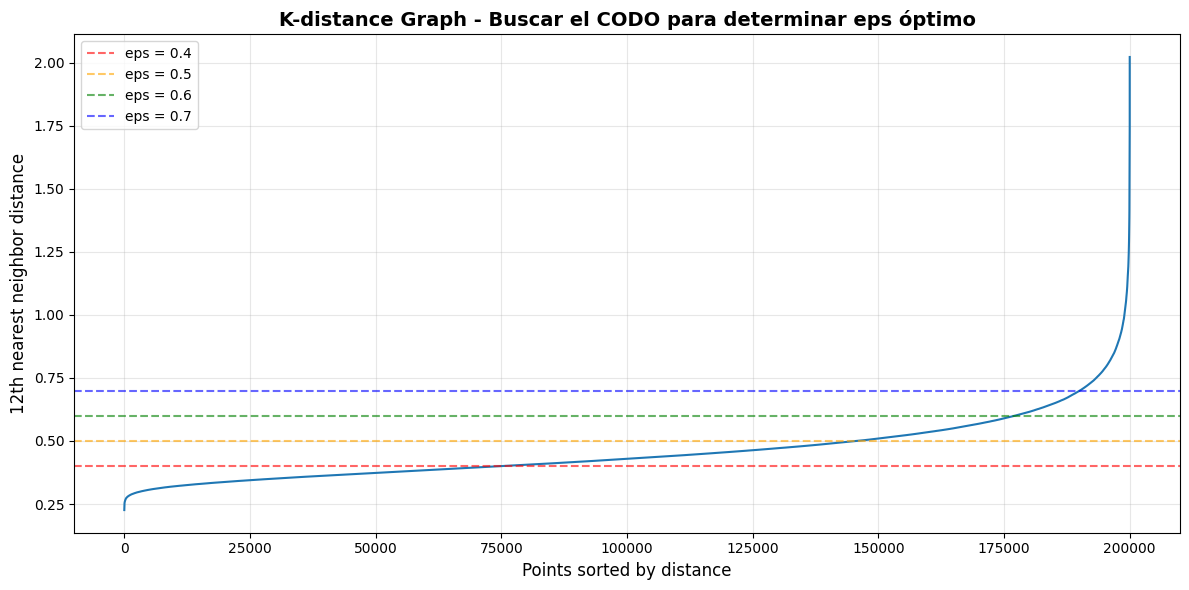

In [12]:
#We plot knn to try to choose an apropriate value for epsilon
min_samples = 12
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_sample_scaled_df.values)
distances, indices = neighbors_fit.kneighbors(X_sample_scaled_df.values)
distances = np.sort(distances[:, min_samples-1])

plt.figure(figsize=(12, 6))
plt.plot(distances, linewidth=1.5)
plt.ylabel(f"{min_samples}th nearest neighbor distance", fontsize=12)
plt.xlabel("Points sorted by distance", fontsize=12)
plt.title("K-distance Graph - Buscar el CODO para determinar eps óptimo", 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# we indicate some candidate values
eps_candidates = [0.4, 0.5, 0.6, 0.7]
colors = ['red', 'orange', 'green', 'blue']
for eps, color in zip(eps_candidates, colors):
    plt.axhline(y=eps, color=color, linestyle='--', alpha=0.6, 
                label=f'eps = {eps}')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [14]:
min_samples = 12

# Model 1: eps = 0.4
print("\n[1/4] Training eps=0.4 model...")
clusterer_04 = DBSCAN(eps=0.4, min_samples=min_samples, metric='euclidean')
y_pred_04 = clusterer_04.fit_predict(X_sample_scaled_df)
n_clusters_04 = len(set(y_pred_04)) - (1 if -1 in y_pred_04 else 0)
n_noise_04 = list(y_pred_04).count(-1)
print(f"   ✓ Complete: {n_clusters_04} clusters, {n_noise_04} noise")

# Model 2: eps = 0.5
print("\n[2/4] Training eps=0.5 model...")
clusterer_05 = DBSCAN(eps=0.5, min_samples=min_samples, metric='euclidean')
y_pred_05 = clusterer_05.fit_predict(X_sample_scaled_df)
n_clusters_05 = len(set(y_pred_05)) - (1 if -1 in y_pred_05 else 0)
n_noise_05 = list(y_pred_05).count(-1)
print(f"   ✓ Complete: {n_clusters_05} clusters, {n_noise_05} noise")

# Model 3: eps = 0.6
print("\n[3/4] Training eps=0.6 model...")
clusterer_06 = DBSCAN(eps=0.6, min_samples=min_samples, metric='euclidean')
y_pred_06 = clusterer_06.fit_predict(X_sample_scaled_df)
n_clusters_06 = len(set(y_pred_06)) - (1 if -1 in y_pred_06 else 0)
n_noise_06 = list(y_pred_06).count(-1)
print(f"   ✓ Complete: {n_clusters_06} clusters, {n_noise_06} noise")

# Model 4: eps = 0.7
print("\n[4/4] Training eps=0.7 model...")
clusterer_07 = DBSCAN(eps=0.7, min_samples=min_samples, metric='euclidean')
y_pred_07 = clusterer_07.fit_predict(X_sample_scaled_df)
n_clusters_07 = len(set(y_pred_07)) - (1 if -1 in y_pred_07 else 0)
n_noise_07 = list(y_pred_07).count(-1)
print(f"   ✓ Complete: {n_clusters_07} clusters, {n_noise_07} noise")


[1/4] Training eps=0.4 model...
   ✓ Complete: 108 clusters, 83299 noise

[2/4] Training eps=0.5 model...
   ✓ Complete: 20 clusters, 26278 noise

[3/4] Training eps=0.6 model...
   ✓ Complete: 3 clusters, 8528 noise

[4/4] Training eps=0.7 model...
   ✓ Complete: 1 clusters, 2927 noise


DBSCAN - Model Evaluation

In [ ]:
# Evaluation functions
def compute_silhouette(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return None
    return silhouette_score(X_scaled[mask], labels[mask])

def compute_davies_bouldin(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return None
    return davies_bouldin_score(X_scaled[mask], labels[mask])

def compute_calinski_harabasz(X_scaled, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) <= 1:
        return None
    return calinski_harabasz_score(X_scaled[mask], labels[mask])

def evaluate_model(X_scaled, labels, eps):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    n_total = len(labels)
    noise_pct = (n_noise / n_total) * 100
    
    print(f"\n{'='*60}")
    print(f"MODEL: eps={eps}")
    print(f"{'='*60}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Data in clusters: {n_total - n_noise}")
    print(f"Noise: {n_noise} ({noise_pct:.2f}%)")
    
    sil = compute_silhouette(X_scaled, labels)
    dbi = compute_davies_bouldin(X_scaled, labels)
    chi = compute_calinski_harabasz(X_scaled, labels)
    
    if sil is not None:
        print(f"\nMetrics:")
        print(f"  Silhouette Score: {sil:.4f}")
        print(f"  Davies-Bouldin Index: {dbi:.4f}")
        print(f"  Calinski-Harabasz Index: {chi:.2f}")
    else:
        print(f"\n⚠️  Metrics not computable (≤1 cluster)")
    
    return {
        'eps': eps,
        'n_clusters': n_clusters,
        'n_points_in_clusters': n_total - n_noise,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'silhouette': sil,
        'davies_bouldin': dbi,
        'calinski_harabasz': chi
    }

# ============================================================
# EVALUATION OF THE 4 MODELS
# ============================================================

results = []

# Evaluate model 1: eps=0.4
result_04 = evaluate_model(X_sample_scaled_df.values, y_pred_04, eps=0.4)
results.append(result_04)

# Evaluate model 2: eps=0.5
result_05 = evaluate_model(X_sample_scaled_df.values, y_pred_05, eps=0.5)
results.append(result_05)

# Evaluate model 3: eps=0.6
result_06 = evaluate_model(X_sample_scaled_df.values, y_pred_06, eps=0.6)
results.append(result_06)

# Evaluate model 4: eps=0.7
result_07 = evaluate_model(X_sample_scaled_df.values, y_pred_07, eps=0.7)
results.append(result_07)

# ============================================================
# COMPARISON TABLE
# ============================================================

print(f"\n{'='*60}")
print("COMPARISON TABLE")
print(f"{'='*60}\n")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# ============================================================
# IDENTIFY THE BEST MODEL
# ============================================================

print(f"\n{'='*60}")
print("BEST MODEL")
print(f"{'='*60}")

valid_models = df_results[df_results['silhouette'].notna()]

if len(valid_models) > 0:
    best_idx = valid_models['silhouette'].idxmax()
    best_model = df_results.loc[best_idx]
    
    print(f"\n🏆 Best model: eps={best_model['eps']}")
    print(f"   Silhouette Score: {best_model['silhouette']:.4f}")
    print(f"   Davies-Bouldin Index: {best_model['davies_bouldin']:.4f}")
    print(f"   Calinski-Harabasz Index: {best_model['calinski_harabasz']:.2f}")
    print(f"   Clusters: {int(best_model['n_clusters'])}")
    print(f"   Noise: {best_model['noise_pct']:.2f}%")
    
    # Evaluación del mejor modelo
    print(f"\n📊 Evaluation:")
    if best_model['silhouette'] > 0.5:
        print("   ✅ Silhouette > 0.5: Excelent")
    elif best_model['silhouette'] > 0.3:
        print("   ✅ Silhouette > 0.3: Good")
    elif best_model['silhouette'] > 0.2:
        print("   ⚠️  Silhouette > 0.2: Acceptable")
    elif best_model['silhouette'] > 0:
        print("   ⚠️  Silhouette > 0: Low")
    else:
        print("   ❌ Silhouette < 0: Bad (incorrect clusters)")
else:
    print("\n❌ No model produced valid results")
    print("   All models have ≤1 cluster")

print(f"{'='*60}")



MODEL: eps=0.4
Number of clusters: 108
Data in clusters: 116700
Noise: 83299 (41.65%)

Metrics:
  Silhouette Score: -0.4672
  Davies-Bouldin Index: 0.9005
  Calinski-Harabasz Index: 23.70

MODEL: eps=0.5
Number of clusters: 20
Data in clusters: 173721
Noise: 26278 (13.14%)

Metrics:
  Silhouette Score: -0.2600
  Davies-Bouldin Index: 0.7894
  Calinski-Harabasz Index: 18.86

MODEL: eps=0.6
Number of clusters: 3
Data in clusters: 191471
Noise: 8528 (4.26%)

Metrics:
  Silhouette Score: 0.1600
  Davies-Bouldin Index: 0.6280
  Calinski-Harabasz Index: 30.20

MODEL: eps=0.7
Number of clusters: 1
Data in clusters: 197072
Noise: 2927 (1.46%)

⚠️  Metrics not computable (≤1 cluster)

COMPARISON TABLE

 eps  n_clusters  n_points_in_clusters  n_noise  noise_pct  silhouette  davies_bouldin  calinski_harabasz
 0.4         108                116700    83299  41.649708   -0.467215        0.900508          23.700776
 0.5          20                173721    26278  13.139066   -0.259960        0.7893

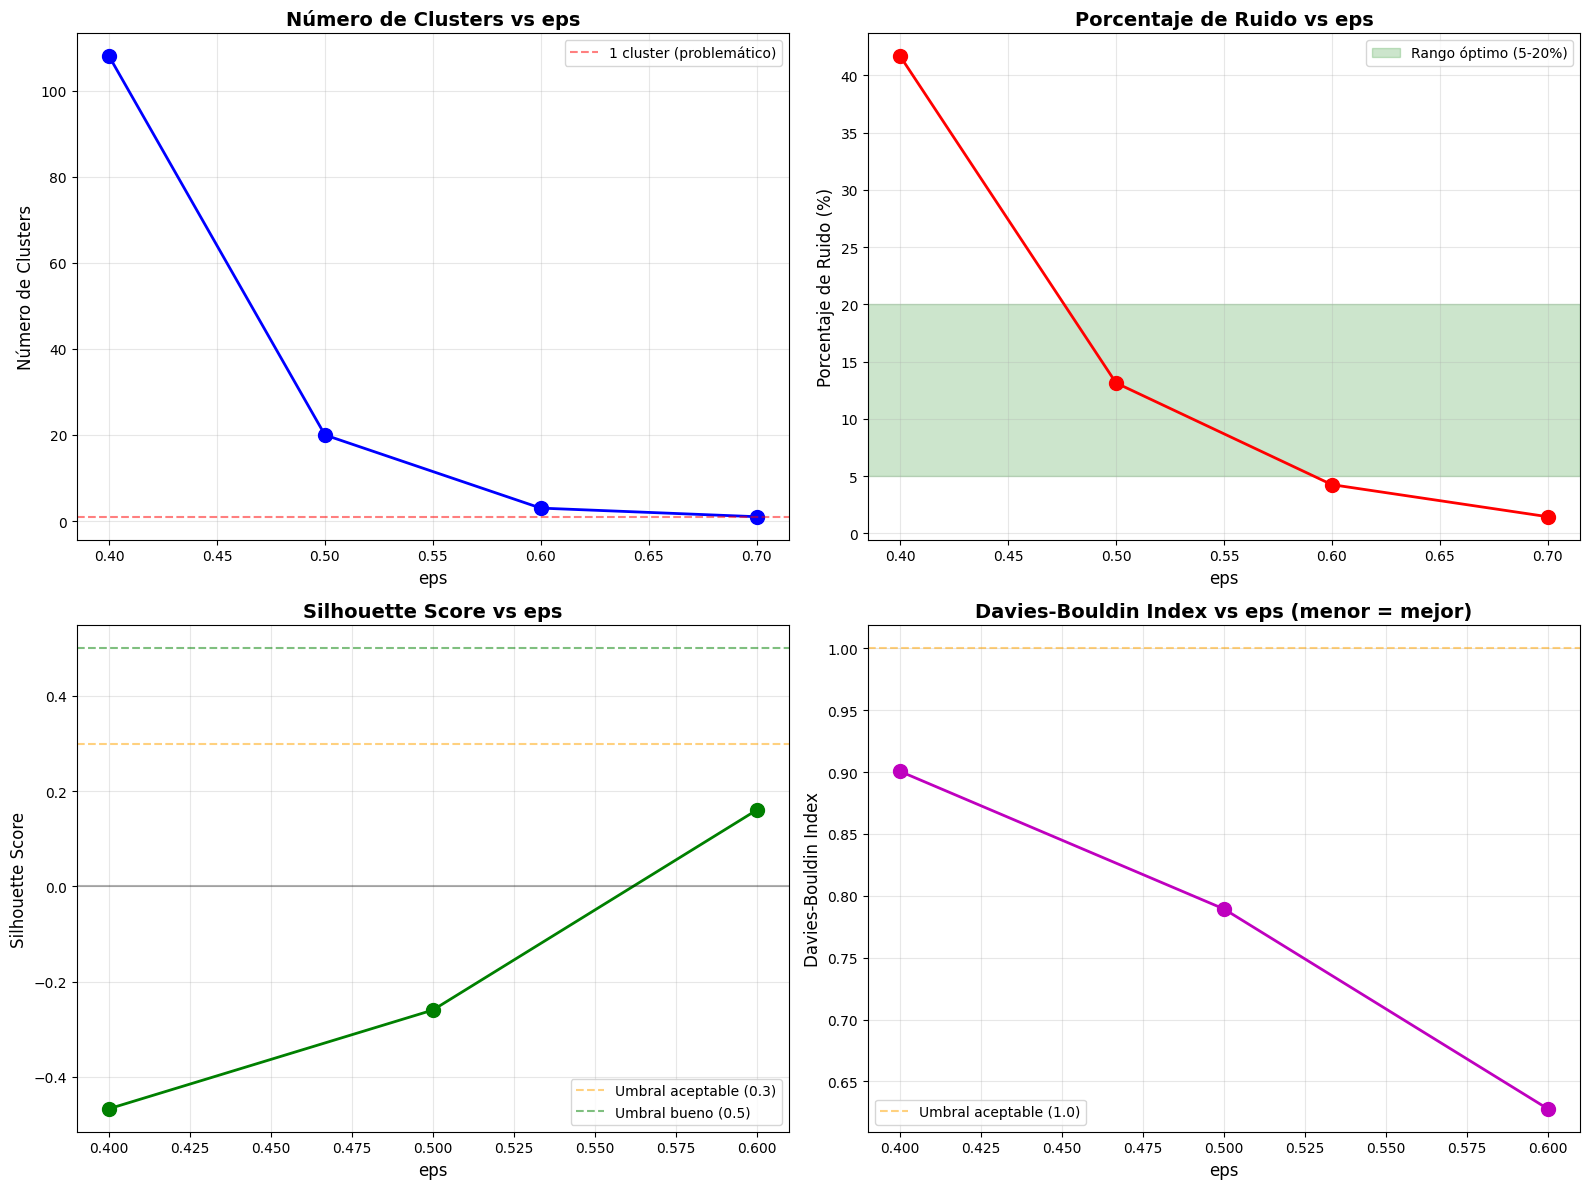

In [16]:
# ============================================================
# VISUALIZACIÓN COMPARATIVA
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Número de clusters vs eps
ax1 = axes[0, 0]
ax1.plot(df_results['eps'], df_results['n_clusters'], 'bo-', 
         linewidth=2, markersize=10)
ax1.set_xlabel('eps', fontsize=12)
ax1.set_ylabel('Número de Clusters', fontsize=12)
ax1.set_title('Número de Clusters vs eps', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 cluster (problemático)')
ax1.legend()

# Gráfico 2: Porcentaje de ruido vs eps
ax2 = axes[0, 1]
ax2.plot(df_results['eps'], df_results['noise_pct'], 'ro-', 
         linewidth=2, markersize=10)
ax2.set_xlabel('eps', fontsize=12)
ax2.set_ylabel('Porcentaje de Ruido (%)', fontsize=12)
ax2.set_title('Porcentaje de Ruido vs eps', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhspan(5, 20, alpha=0.2, color='green', label='Rango óptimo (5-20%)')
ax2.legend()

# Gráfico 3: Silhouette Score vs eps
ax3 = axes[1, 0]
valid_sil = df_results[df_results['silhouette'].notna()]
if len(valid_sil) > 0:
    ax3.plot(valid_sil['eps'], valid_sil['silhouette'], 'go-', 
             linewidth=2, markersize=10)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, 
                label='Umbral aceptable (0.3)')
    ax3.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, 
                label='Umbral bueno (0.5)')
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'No hay valores válidos', 
             ha='center', va='center', fontsize=14, transform=ax3.transAxes)
ax3.set_xlabel('eps', fontsize=12)
ax3.set_ylabel('Silhouette Score', fontsize=12)
ax3.set_title('Silhouette Score vs eps', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Davies-Bouldin Index vs eps
ax4 = axes[1, 1]
valid_dbi = df_results[df_results['davies_bouldin'].notna()]
if len(valid_dbi) > 0:
    ax4.plot(valid_dbi['eps'], valid_dbi['davies_bouldin'], 'mo-', 
             linewidth=2, markersize=10)
    ax4.axhline(y=1.0, color='orange', linestyle='--', alpha=0.5, 
                label='Umbral aceptable (1.0)')
    ax4.legend()
else:
    ax4.text(0.5, 0.5, 'No hay valores válidos', 
             ha='center', va='center', fontsize=14, transform=ax4.transAxes)
ax4.set_xlabel('eps', fontsize=12)
ax4.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax4.set_title('Davies-Bouldin Index vs eps (menor = mejor)', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

GAUSSIAN MIXTURE

In [ ]:
# =====================================================
#   Gaussian Mixture Model (Final Improved Version)
# =====================================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

# Prevent BLAS over-threading issues (optional but safe)
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

print("Running improved Gaussian Mixture Model...\n")

# =====================================================
# 1. PREPROCESSING  (MANDATORY FOR GMM)
# =====================================================
# Select ONLY numerical columns for GMM
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Scale only numeric columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)
df_gmm = df.copy()                          


# =====================================================
# 2. MODEL SELECTION (k + covariance type) USING BIC/AIC
# =====================================================
n_components_range = range(1, 11)
cov_types = ["full", "tied", "diag", "spherical"]

results = []

for cov in cov_types:
    for k in n_components_range:
        gm = GaussianMixture(
            n_components=k,
            covariance_type=cov,
            random_state=42,
            n_init=3,
            max_iter=150
        )
        try:
            gm.fit(X_scaled)
            results.append({
                "covariance": cov,
                "k": k,
                "bic": gm.bic(X_scaled),
                "aic": gm.aic(X_scaled),
                "model": gm
            })
            print(f"[OK] cov={cov} | k={k} | BIC={gm.bic(X_scaled):.1f} | AIC={gm.aic(X_scaled):.1f}")
        except Exception as e:
            print(f"[Skip] cov={cov}, k={k}: {str(e)[:50]}")
            continue

print("\nModel selection complete.\n")

# Convert to DataFrame and pick best model
gmm_df = pd.DataFrame(results)
best_row = gmm_df.loc[gmm_df["bic"].idxmin()]
best_k = int(best_row["k"])
best_cov = best_row["covariance"]
best_model = best_row["model"]

print("===== BEST GMM MODEL =====")
print(f"Covariance type:   {best_cov}")
print(f"Components (k):    {best_k}")
print(f"Best BIC:          {best_row['bic']:.2f}")
print(f"Best AIC:          {best_row['aic']:.2f}\n")


# =====================================================
# 3. FINAL FIT + CLUSTER ASSIGNMENTS
# =====================================================
labels = best_model.predict(X_scaled)
probs = best_model.predict_proba(X_scaled)

df_gmm["GMM_Label"] = labels
df_gmm["GMM_MaxProb"] = probs.max(axis=1)

# Store full probability distribution per cluster
for c in range(best_k):
    df_gmm[f"GMM_Prob_{c}"] = probs[:, c]

print("Cluster counts:")
print(df_gmm["GMM_Label"].value_counts())


# =====================================================
# 4. SILHOUETTE SCORE (sample of 20,000 for speed)
# =====================================================
X_sample, labels_sample = shuffle(X_scaled, labels, n_samples=20000, random_state=42)

sil = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score (sampled): {sil:.4f}")


# =====================================================
# 5. PCA VISUALIZATION (2D)
# =====================================================
pca = PCA(n_components=2)
X_2d_full = pca.fit_transform(X_scaled)

# Sample for visualization (20k points)
idx = np.random.choice(len(X_scaled), 20000, replace=False)
X_2d = X_2d_full[idx]
labels_sampled = labels[idx]

plt.figure(figsize=(8,6))
for c in range(best_k):
    plt.scatter(X_2d[labels_sampled == c, 0],
                X_2d[labels_sampled == c, 1],
                s=20, alpha=0.6,
                label=f"Cluster {c}")
plt.title("GMM clusters (sampled PCA)")
plt.show()

print("\nGMM clustering completed successfully.")


Running improved Gaussian Mixture Model...

[OK] cov=full | k=1 | BIC=18239342.3 | AIC=18238432.5
[OK] cov=full | k=2 | BIC=5008794.5 | AIC=5006963.1
[OK] cov=full | k=3 | BIC=-274560.3 | AIC=-277313.3
[OK] cov=full | k=4 | BIC=-2297111.6 | AIC=-2300786.2


## GMM Cluster Profiling and Comparison

=== GMM CLUSTER PROFILES ===

              BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore  \
GMM_Label                                                                       
0          9.474128e+06         3.014844e+07    6.521105            64.930883   
1          8.226035e+06         1.339715e+07    7.073054            73.011560   
2          1.003939e+07         2.865142e+07    9.218843           100.000000   
3          9.740387e+06         9.741003e+06    6.447765            64.141896   
4          1.119484e+07         2.245912e+07    5.973468            57.517651   
5          9.853109e+06         4.340716e+07    6.394381            63.516102   
6          9.553952e+06         2.231427e+07    6.402077            63.792832   
7          9.908939e+06         2.740490e+07    6.486720            64.757178   

           Movie_Count  
GMM_Label               
0                37299  
1                18166  
2                 4617  
3                19169  
4        

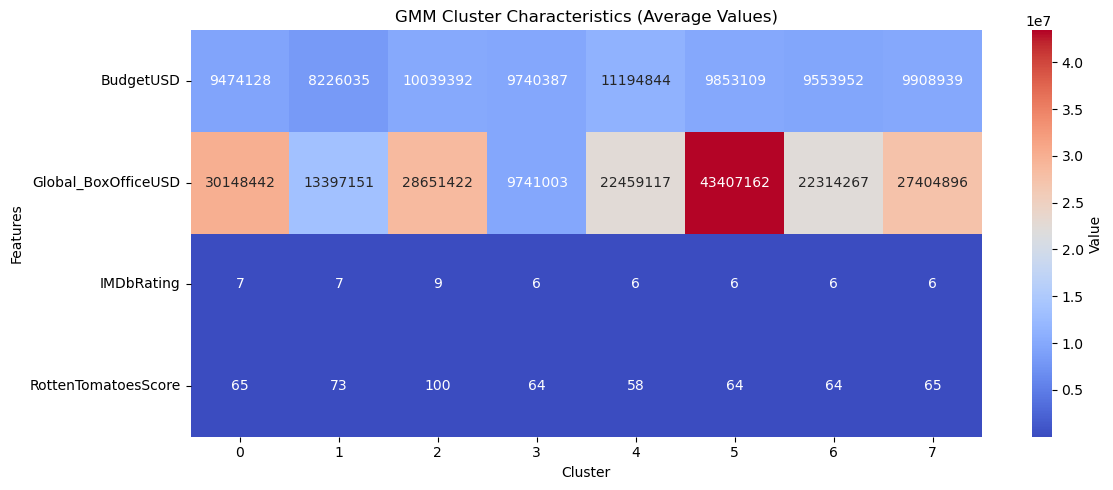

In [ ]:
# === GMM CLUSTER PROFILING ===
print("=== GMM CLUSTER PROFILES ===\n")

numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
gmm_profile = df_sample.groupby('GMM_Label')[numeric_cols].mean()
gmm_profile['Movie_Count'] = df_sample['GMM_Label'].value_counts().sort_index()

print(gmm_profile)
print("\n")

# Heatmap for visualization
plt.figure(figsize=(12, 5))
sns.heatmap(gmm_profile.drop(columns='Movie_Count').T, cmap='coolwarm', annot=True, fmt=".0f", cbar_kws={'label': 'Value'})
plt.title("GMM Cluster Characteristics (Average Values)")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


MODEL EVALUATION

===== GMM MODEL EVALUATION =====

Log-Likelihood: 3036978.01
BIC: -6063193.75
AIC: -6072398.03
Sampled Silhouette Score (n=20000): -0.0214

Cluster Sizes:
5    165152
1    144757
8    143546
0    130636
6    106259
7     89851
3     88377
4     66772
2     40767
9     23882
Name: count, dtype: int64

Soft Assignment Probability Summary:
count    999999.000000
mean          0.911003
std           0.134451
min           0.266665
25%           0.883517
50%           0.980864
75%           0.996532
max           1.000000
dtype: float64

Number of low-confidence assignments (<0.6 prob): 58215


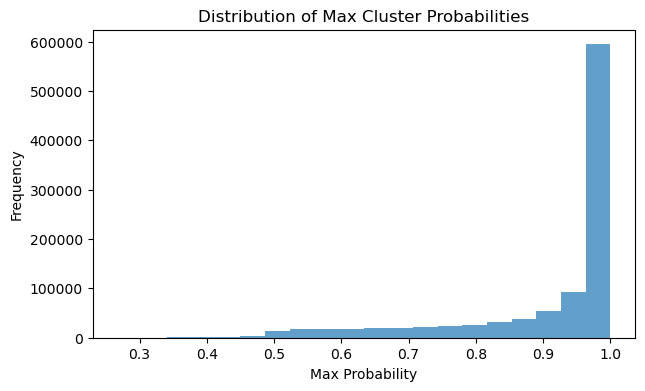

In [25]:
# =====================================================
#   GMM MODEL EVALUATION SECTION
# =====================================================

from sklearn.metrics import silhouette_score

print("===== GMM MODEL EVALUATION =====\n")

# 1. Log-likelihood of the model
log_likelihood = best_model.score(X_scaled) * X_scaled.shape[0]
print(f"Log-Likelihood: {log_likelihood:.2f}")

# 2. BIC & AIC
bic = best_model.bic(X_scaled)
aic = best_model.aic(X_scaled)
print(f"BIC: {bic:.2f}")
print(f"AIC: {aic:.2f}")

# Silhouette on a sample of 20,000 points
from sklearn.metrics import silhouette_score

sample_size = 20000
idx = np.random.choice(len(X_scaled), size=sample_size, replace=False)

sil_score = silhouette_score(X_scaled[idx], labels[idx])
print(f"Sampled Silhouette Score (n={sample_size}): {sil_score:.4f}")


# 4. Cluster sizes
print("\nCluster Sizes:")
print(pd.Series(labels).value_counts())

# 5. Soft assignment certainty
max_probs = probs.max(axis=1)
print("\nSoft Assignment Probability Summary:")
print(pd.Series(max_probs).describe())

# 6. Count low-confidence assignments (ambiguous)
low_confidence = (max_probs < 0.6).sum()
print(f"\nNumber of low-confidence assignments (<0.6 prob): {low_confidence}")

# 7. Plot cluster probability distribution
plt.figure(figsize=(7,4))
plt.hist(max_probs, bins=20, alpha=0.7)
plt.title("Distribution of Max Cluster Probabilities")
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.show()


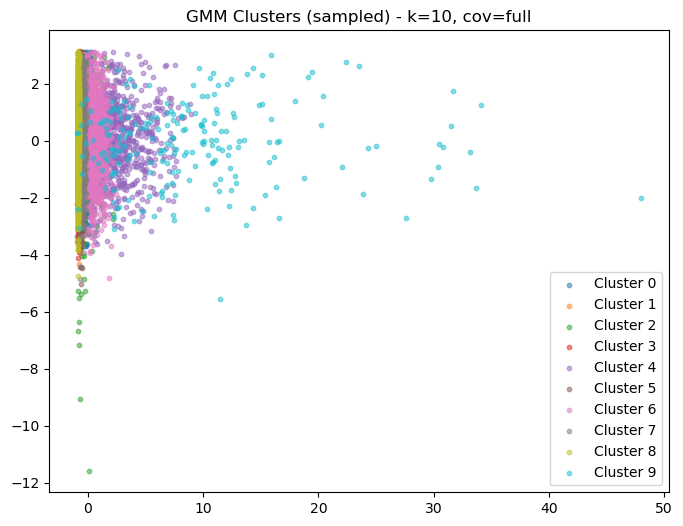

In [26]:
# Sample only 10k points for PCA visualization
sample_idx = np.random.choice(len(X_scaled), size=10000, replace=False)
X_sample = X_scaled[sample_idx]
labels_sample = labels[sample_idx]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(8,6))
for c in range(best_k):
    mask = labels_sample == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, alpha=0.5, label=f"Cluster {c}")

plt.title(f"GMM Clusters (sampled) - k={best_k}, cov={best_cov}")
plt.legend()
plt.show()


Comparison of All Clustering Methods

In [ ]:
# === COMPARISON: ALL CLUSTERING METHODS ===
print("=" * 70)
print("CLUSTERING METHODS COMPARISON SUMMARY")
print("=" * 70)

# 1. Cluster Distribution
print("\n1. CLUSTER DISTRIBUTION:")
print("-" * 70)
print("\nK-Means Cluster Sizes:")
print(df_sample['Cluster'].value_counts().sort_index())
print("\nBIRCH Cluster Sizes:")
print(df_sample['Cluster_BIRCH'].value_counts().sort_index())
print("\nGMM Cluster Sizes:")
print(df_sample['GMM_Label'].value_counts().sort_index())

# 2. Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df_sample['Cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('K-Means Cluster Distribution')
axes[0].set_ylabel('Number of Movies')
axes[0].set_xlabel('Cluster')

df_sample['Cluster_BIRCH'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('BIRCH Cluster Distribution')
axes[1].set_ylabel('Number of Movies')
axes[1].set_xlabel('Cluster')

df_sample['GMM_Label'].value_counts().sort_index().plot(kind='bar', ax=axes[2], color='salmon', edgecolor='black')
axes[2].set_title('GMM Cluster Distribution')
axes[2].set_ylabel('Number of Movies')
axes[2].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

# 3. Key insights
print("\n2. KEY INSIGHTS:")
print("-" * 70)
print(f"K-Means: {df_sample['Cluster'].nunique()} clusters (manual k=4)")
print(f"BIRCH: {df_sample['Cluster_BIRCH'].nunique()} clusters (threshold=1.5, k=4)")
print(f"GMM: {df_sample['GMM_Label'].nunique()} components (best BIC: cov={best_cov}, k={best_k})")
print(f"\nGMM Silhouette Score: {sil:.4f}")
print(f"GMM Average Confidence (max probability): {df_sample['GMM_MaxProb'].mean():.4f}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)
